__File: spectroscopic_factors.ipynb__

__Author:   A. J. Tropiano (tropiano.4@osu.edu)__<br/>
__Date:     Oct 8, 2021__

SRG-evolving spectroscopic factors using similar analysis to momentum distribution calculations with s.p. wave functions from HFBRAD code.

__Revision history:<br/>__
* Oct 19, 2021 - Finished first pass at spectroscopic factor code. Organizing wave functions from HFBRAD code according to s.p. states (e.g., '1s0p5' meaning $1s$ and $j=1/2$).

In [1]:
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import numpy as np
from numpy.polynomial.legendre import leggauss
from scipy.interpolate import interp1d, RectBivariateSpline
from scipy.special import spherical_jn
# Scripts made by A.T.
import densities as den
from figures import figures_functions as ff
from misc.integration import gaussian_quadrature_mesh
from potentials.vsrg_macos import vnn
from srg.srg_unitary_transformation import SRG_unitary_transformation

# Set-up

In [2]:
def setup_rc_params(presentation=False):
    """
    Set matplotlib's rc parameters for the plots
    
    Parameters
    ----------
    presentation : bool, optional
        Option to enlarge font sizes for presentations.
    
    """

    if presentation:
        fontsize = 14
    else:
        fontsize = 9
    black = 'k'

    mpl.rcdefaults()  # Set to defaults

    mpl.rc('text', usetex=True)
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams['font.family'] = 'serif'

#     mpl.rcParams['axes.labelsize'] = fontsize
    mpl.rcParams['axes.edgecolor'] = black
    # mpl.rcParams['axes.xmargin'] = 0
    mpl.rcParams['axes.labelcolor'] = black
#     mpl.rcParams['axes.titlesize'] = fontsize

    mpl.rcParams['ytick.direction'] = 'in'
    mpl.rcParams['xtick.direction'] = 'in'
    mpl.rcParams['xtick.labelsize'] = fontsize
    mpl.rcParams['ytick.labelsize'] = fontsize
    mpl.rcParams['xtick.color'] = black
    mpl.rcParams['ytick.color'] = black
    # Make the ticks thin enough to not be visible at the limits of the plot (over the axes border)
    mpl.rcParams['xtick.major.width'] = mpl.rcParams['axes.linewidth'] * 0.95
    mpl.rcParams['ytick.major.width'] = mpl.rcParams['axes.linewidth'] * 0.95
    # The minor ticks are little too small, make them both bigger.
    mpl.rcParams['xtick.minor.size'] = 2.4  # Default 2.0
    mpl.rcParams['ytick.minor.size'] = 2.4
    mpl.rcParams['xtick.major.size'] = 3.9  # Default 3.5
    mpl.rcParams['ytick.major.size'] = 3.9
    
    # Added by A.T.
    # Puts tick marks (not labels) on top and right axes
    mpl.rcParams['xtick.top'] = True
    mpl.rcParams['ytick.right'] = True
    
    ppi = 72  # points per inch
    # dpi = 150
#     mpl.rcParams['figure.titlesize'] = fontsize
    mpl.rcParams['figure.dpi'] = 150  # To show up reasonably in notebooks
    mpl.rcParams['figure.constrained_layout.use'] = False
    # 0.02 and 3 points are the defaults:
    # can be changed on a plot-by-plot basis using fig.set_constrained_layout_pads()
    mpl.rcParams['figure.constrained_layout.wspace'] = 0.0
    mpl.rcParams['figure.constrained_layout.hspace'] = 0.0
    mpl.rcParams['figure.constrained_layout.h_pad'] = 3. / ppi  # 3 points
    mpl.rcParams['figure.constrained_layout.w_pad'] = 3. / ppi

#     mpl.rcParams['legend.title_fontsize'] = fontsize
#     mpl.rcParams['legend.fontsize'] = fontsize
    mpl.rcParams['legend.edgecolor'] = 'inherit'  # inherits from axes.edgecolor, to match
    # Set facecolor with its own alpha, so edgecolor is unaffected
    mpl.rcParams['legend.fancybox'] = True
    mpl.rcParams['legend.facecolor'] = (1, 1, 1, 0.6)
#     mpl.rcParams['legend.borderaxespad'] = 0.8
    # Do not set overall alpha (affects edgecolor). Handled by facecolor above
    mpl.rcParams['legend.framealpha'] = None
    # This is for legend edgewidth, since it does not have its own option
    mpl.rcParams['patch.linewidth'] = 0.8
    mpl.rcParams['hatch.linewidth'] = 0.5

    # bbox = 'tight' can distort the figure size when saved (that's its purpose).
    # mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.04, dpi=350, format='png')
    # mpl.rc('savefig', transparent=False, bbox=None, dpi=400, format='png')
    mpl.rc('savefig', bbox='tight', dpi=400)

In [3]:
# Run this cell to customize matplotlib graphics (see setup_rc_params for details)
setup_rc_params(presentation=True)

In [4]:
# Save figures in the following directory
figure_directory = 'figures/knockout_reactions'

# Load s.p. wave functions from the following directory
hfbrad_directory = 'densities/HFBRAD_SLY4'

# Nucleus formatted as (Name, Z, N)
nucleus = ('O16', 8, 8)
# nucleus = ('Pb208', 82, 126)
nucleus_name = nucleus[0]
Z = nucleus[1]
N = nucleus[2]

nucleons = ['proton', 'neutron']

# Load occupied single-particle states
states = den.sp_states(nucleus)

# Store distributions in dictionary with nucleon and s.p. state as keys
d = {}
d['proton'] = {}
d['neutron'] = {}

# Set interaction, channels, \lambda, and momentum mesh
kvnn = 6
channels = ('1S0', '3S1')
lamb = 1.35
kmax = 15.0
kmid = 3.0
ntot = 120

# Momentum array and weights
p_array, p_weights = vnn.load_momentum(kvnn, '1S0', kmax, kmid, ntot)

# For plotting things with respect to energy
hbar_c = 197.327 # MeV fm

# Load coordinate-space single-particle wave functions

In [5]:
# Loop over isospin
for nucleon in nucleons:
    
    if nucleon == 'proton':
        nuc_int = 1
    elif nucleon == 'neutron':
        nuc_int = 0
    
    # Loop over s.p. state and add \phi_{\alpha}(r) to dictionary
    for sp in states[nuc_int]:
        
        file_name = f'{nucleon}_{sp}_{N}_{Z}.gfx'
        d[nucleon][sp] = np.loadtxt( hfbrad_directory + '/%s/wfs/%s' % (nucleus_name, file_name) )

# Plot coordinate-space single-particle wave functions

In [6]:
# Only do a few s.p. states

# Selected O16 proton states
if nucleus_name == 'O16':
    states = ['1s0p5', '1p0p5', '1p1p5']
elif nucleus_name == 'Pb208':
    states = ['1s0p5', '3s0p5', '2d1p5']

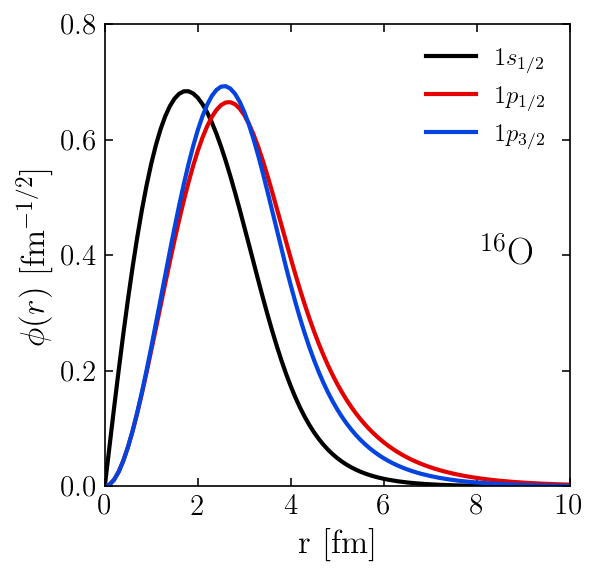

In [7]:
# Figure size
row_number = 1
col_number = 1
figure_size = (4*col_number, 4*row_number)

# Axes labels and fontsize
x_label = 'r [fm]'
x_label_size = 16
y_label = r'$\phi(r)$' + ' [fm' + r'$^{-1/2}$' + ']'
y_label_size = 16

xlim = (0.0, 10.0)
if nucleus_name == 'O16':
    ylim = (0.0, 0.8)
elif nucleus_name == 'Pb208':
    ylim = (-0.7, 0.8)

# Curve width
curve_width = 2.0

# Initialize figure
plt.close('all')
f, ax = plt.subplots(figsize=figure_size)

for i, state in enumerate(states):

    phi_data = d['proton'][state]
    r_array = phi_data[:, 0]
    dr = r_array[1] - r_array[0]
    phi_r_array = phi_data[:, 2]
        
    # Curve color
    curve_color = ff.xkcd_colors(i)
        
    # Curve label
    curve_label = ff.sp_state_label_conversion(state)
        
    ax.plot(r_array, phi_r_array, label=curve_label, linewidth=curve_width, color=curve_color)
        
#     # Print out normalizations
#     print( np.sum(dr*phi_r_array**2) )
        
# Specify axes limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Set axes labels
ax.set_xlabel(x_label, fontsize=x_label_size)
ax.set_ylabel(y_label, fontsize=y_label_size)

# Set legend
legend_size = 12
if nucleus_name == 'O16':
    legend_location = 'upper right'
elif nucleus_name == 'Pb208':
    legend_location = 'lower left'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# Add nucleus label
nucleus_label = ff.nuclei_label_conversion(nucleus_name)
if nucleus_name == 'O16':
    nucleus_label_location = 'center right'
elif nucleus_name == 'Pb208':
    nucleus_label_location = 'upper left'
nucleus_label_size = 18
anchored_text = AnchoredText(nucleus_label, loc=nucleus_label_location, prop=dict(size=nucleus_label_size),
                             frameon=False)
ax.add_artist(anchored_text)

# Transform to momentum-space and plot

In [8]:
def hankel_transformation(l, k_array, r_array, dr):
    """
    <k|r> transformation matrix for given orbital angular momentum l. If
    len(r_array) = m and len(k_array) = n, then this function returns an 
    n x m matrix.
    
    Parameters
    ----------
    l : int
        Orbital angular momentum.
    k_array : 1-D ndarray
        Momentum array [fm^-1].
    r_array : 1-D ndarray
        Coordinates array [fm].
    dr : float
        Coordinates step-size (weight) [fm].
        
    Returns
    -------
    M : 2-D ndarray
        Hankel transformation matrix [fm^3\2].

    """

    # r_array column vectors and k_array row vectors where both grids are
    # n x m matrices
    r_cols, k_rows = np.meshgrid(r_array, k_array)
        
    M = dr * r_cols * spherical_jn(l, k_rows * r_cols)

    return M

0.9999999994896446
0.9999999986107608
1.0000000006434782


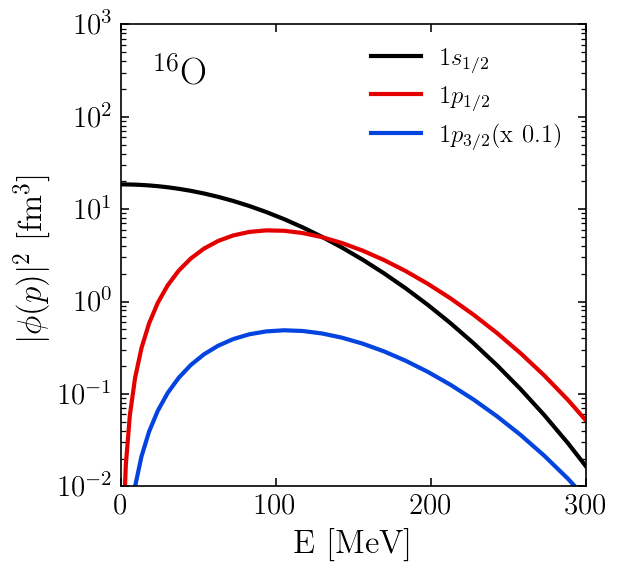

In [9]:
# Figure size
row_number = 1
col_number = 1
figure_size = (4*col_number, 4*row_number)

# Axes labels and fontsize
x_label = 'p [fm' + r'$^{-1}$' + ']'
x_label_size = 16
y_label = r'$|\phi(p)|^2$' + ' [fm' + r'$^{3}$' + ']'
y_label_size = 16

xlim = (0.0, 300.0) # MeV
if nucleus_name == 'O16':
    ylim = (1e-2, 1e3)
elif nucleus_name == 'Pb208':
    ylim = (1e-5, 1e3)

# Curve width
curve_width = 2.0

# Initialize figure
plt.close('all')
f, ax = plt.subplots(figsize=figure_size)

# Loop over isospin
for i, state in enumerate(states):
    
        # Reduce by overall factor as in T. Aumann paper
        if nucleus_name == 'O16' and state == '1p1p5':
            fac = 0.1
        elif nucleus_name == 'Pb208' and state == '2d1p5':
            fac = 0.01
        else:
            fac = 1
        
        phi_data = d['proton'][state]
        r_array = phi_data[:, 0]
        dr = r_array[1] - r_array[0]
        phi_r_array = phi_data[:, 2]
        
        # Transform to momentum-space
        if state[1] == 's':
            l = 0
        elif state[1] == 'p':
            l = 1
        elif state[1] == 'd':
            l = 2
        elif state[1] == 'f':
            l = 3
        ft_matrix = hankel_transformation(l, p_array, r_array, dr)
        phi_p_array = ft_matrix @ phi_r_array
        
        # Curve color
        curve_color = ff.xkcd_colors(i)
        
        # Curve label
        if fac == 1:
            curve_label = ff.sp_state_label_conversion(state)
        elif fac == 0.1:
            curve_label = ff.sp_state_label_conversion(state) + '(x %.1f)' % fac
        elif fac == 0.01:
            curve_label = ff.sp_state_label_conversion(state) + '(x %.2f)' % fac
        
        # Plot with respect to energy
        ax.semilogy(p_array*hbar_c, phi_p_array**2*fac, label=curve_label, linewidth=curve_width,
                    color=curve_color)
        
        # Print out normalizations
        print( 2/np.pi*np.sum(p_weights*p_array**2*phi_p_array**2) )
        
# Specify axes limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Set axes labels
ax.set_xlabel('E [MeV]', fontsize=x_label_size)
ax.set_ylabel(y_label, fontsize=y_label_size)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# Add nucleus label
nucleus_label = ff.nuclei_label_conversion(nucleus_name)
nucleus_label_location = 'upper left'
nucleus_label_size = 18
anchored_text = AnchoredText(nucleus_label, loc=nucleus_label_location, prop=dict(size=nucleus_label_size),
                             frameon=False)
ax.add_artist(anchored_text)

# Spectroscopic factors

Definition of spectroscopic factor for a particular state $\alpha$ from Dickhoff (7.6):

</br>
<div align="center">
$S_{\alpha} = \int d\mathbf{p} \lvert \langle \Psi_{\alpha}^{A-1} \lvert a_{\mathbf{p}} \rvert \Psi_0^A \rangle \rvert^2$.
</div>


If we SRG-evolve the matrix element, and truncate the evolved operator to 2-body level, we arrive at the following:

</br>
<div align="left">
$S_{\alpha}(\lambda) = \int d\mathbf{p} \lvert \phi_{\alpha}(p) \rvert^2$
    </br>$\quad\quad\times\,
    \Bigl| 4\pi \int_0^{\infty} dR R^2 \theta(k_{\rm F}^{\tau}(R)-p)
    \Bigl[ 2 + 16 \sum_{L,S,T}' \sum_{J} \frac{2}{\pi} \int_0^{\infty} dk k^2
                (k (L S) J T \lvert \delta U^{\dagger} \rvert k (L S) J T)
                \sum_{\tau'} \lvert \langle \tau \tau'| T \, \tau+\tau' \rangle \rvert^2
                \int_{-1}^1 \frac{dx}{2}
                \theta( k_{\rm F}^{\tau'}(R) - \lvert \mathbf{p}-2\mathbf{k} \rvert )
    \Bigr]
    \Bigr|^2$
</div>
    


In [10]:
class spectroscopic_factor(object):
    
    
    def __init__(self, kvnn, channels, lamb, kmax, kmid, ntot, generator='Wegner'):
        """
        Evaluates and saves the pp and pn matrix elements of \delta U^{\dagger} given
        the input potential and SRG \lambda.
        
        Parameters
        ----------
        kvnn : int
            This number specifies the potential.
        channels : tuple
            Partial wave channels to include in the calculation.
        lamb : float
            SRG evolution parameter lambda [fm^-1].
        kmax : float
            Maximum value in the momentum mesh [fm^-1]. (Default of zero
            automatically selects default mesh based on kvnn.)
        kmid : float
            Mid-point value in the momentum mesh [fm^-1].
        ntot : int
            Number of momentum points in mesh.
        generator : str, optional
            SRG generator 'Wegner', 'T', or 'Block-diag'.
            
        """
        
        # Get relevant info for file and directory names
        # Part of data directory name
        self.kvnn = kvnn 
        # Part of file name
        self.channels = channels
        self.lamb = lamb
        self.kmax = kmax
        self.generator = generator
        
        # Save highest allowed L based on input channels
        highest_L = 0
        for channel in channels:
            next_L = vnn.channel_L_value(channel)
            if next_L > highest_L:
                highest_L = next_L

        # Load and save momentum arrays
        k_array, k_weights = vnn.load_momentum(kvnn, '1S0', kmax, kmid, ntot)
        self.p_array, self.p_weights = k_array, k_weights
            
        # For dividing out momenta/weights
        factor_array = np.sqrt( (2*k_weights) / np.pi ) * k_array
        # For coupled-channel matrices
        factor_array_cc = np.concatenate( (factor_array, factor_array) )

        # Initialize pp and pn matrix elements
        deltaU_pp = np.zeros( (ntot, ntot) ) # \delta U linear term
        deltaU_pn = np.zeros( (ntot, ntot) )
        deltaU2_pp = np.zeros( (ntot, ntot) ) # \delta U \delta U^\dagger
        deltaU2_pn = np.zeros( (ntot, ntot) )
        
        # Allowed channels for pp (and nn) up through the D-waves
        pp_channels = ('1S0', '3P0', '3P1', '3P2', '1D2')
        
        # Loop over channels and evaluate matrix elements
        for channel in channels:

            # Load SRG transformation
            H_initial = vnn.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
            if generator == 'Block-diag':
                # Take \lambda = 1 fm^-1 and set \Lambda_BD = input \lambda
                H_evolved = vnn.load_hamiltonian(kvnn, channel, kmax, kmid, ntot,
                                                 'srg', generator, 1.0, lamb)
            else:
                H_evolved = vnn.load_hamiltonian(kvnn, channel, kmax, kmid, ntot,
                                                 'srg', generator, lamb)
            # Load U(k, k') [unitless]
            U_matrix_unitless = SRG_unitary_transformation(H_initial, H_evolved)

            # Isolate 2-body term and convert to fm^3
            if vnn.coupled_channel(channel):
                I_matrix_unitless = np.eye( 2*ntot, 2*ntot )
                row, col = np.meshgrid(factor_array_cc, factor_array_cc)
            else:
                I_matrix_unitless = np.eye(ntot, ntot)
                row, col = np.meshgrid(factor_array, factor_array)
            delta_U_matrix_unitless = U_matrix_unitless - I_matrix_unitless
            delta_U_matrix = delta_U_matrix_unitless / row / col # fm^3
            
            # 2J+1 factor
            J = int( channel[-1] )
            
            # Add to the pp and pn terms
            # Coupled-channel
            if vnn.coupled_channel(channel):
                    
                # First L of coupled-channel
                # Isospin CG's=1/\sqrt(2) for pn
                deltaU_pn += (2*J+1)/2 * delta_U_matrix[:ntot, :ntot]
                deltaU2_pn += (2*J+1)/2 * ( \
                                  delta_U_matrix[:ntot, :ntot]**2 + \
                                  delta_U_matrix[:ntot, ntot:]**2 )

                # Isospin CG's=1 for pp
                if channel in pp_channels:
                    deltaU_pp += (2*J+1) * delta_U_matrix[:ntot, :ntot]
                    deltaU2_pp += (2*J+1) * ( \
                                      delta_U_matrix[:ntot, :ntot]**2 \
                                    + delta_U_matrix[:ntot, ntot:]**2 )
                    
                # Decide whether to add second L based on highest allowed
                # L value (e.g., 0 + 2 <= 2 meaning we include the 3D1-3D1
                # part of the coupled 3S1-3D1 channel if we input D-waves
                # in channels)
                if vnn.channel_L_value(channel) + 2 <= highest_L:
                    deltaU_pn += (2*J+1)/2 * delta_U_matrix[ntot:, ntot:]
                    deltaU2_pn += (2*J+1)/2 * ( \
                                      delta_U_matrix[ntot:, :ntot]**2 + \
                                      delta_U_matrix[ntot:, ntot:]**2 )
                        
                    if channel in pp_channels:
                        deltaU_pp += (2*J+1) * delta_U_matrix[ntot:, ntot:]
                        deltaU2_pp += (2*J+1) * ( \
                                          delta_U_matrix[ntot:, :ntot]**2 + \
                                          delta_U_matrix[ntot:, ntot:]**2 )
            
            else:
                
                # Isospin CG's=1/\sqrt(2) for pn
                deltaU_pn += (2*J+1)/2 * delta_U_matrix
                deltaU2_pn += (2*J+1)/2 * delta_U_matrix**2
                
                # Isospin CG's=1 for pp
                if channel in pp_channels:
                    deltaU_pp += (2*J+1) * delta_U_matrix
                    deltaU2_pp += (2*J+1) * delta_U_matrix**2

        # Interpolate pp and pn < k | \delta U | k >
        self.deltaU_pp_func = interp1d( k_array, np.diag(deltaU_pp), kind='linear', bounds_error=False,
                                        fill_value='extrapolate' )
        self.deltaU_pn_func = interp1d( k_array, np.diag(deltaU_pn), kind='linear', bounds_error=False,
                                        fill_value='extrapolate' )
        
        # Interpolate pp and pn < k | \delta U \delta U^{\dagger} | k' > 
        self.deltaU2_pp_func = RectBivariateSpline(k_array, k_array, deltaU2_pp, kx=1, ky=1)
        self.deltaU2_pn_func = RectBivariateSpline(k_array, k_array, deltaU2_pn, kx=1, ky=1)


    def theta_I(self, p_mesh, kF1_mesh):
        """
        Evaluates \theta( kF1(R) - p ). This function appears in the I term.

        Parameters
        ----------
        p_mesh : 2-D ndarray
            Momentum values [fm^-1].
        kF1_mesh : 2-D ndarray
            Fermi momentum [fm^-1] for the nucleon corresponding to \tau with
            respect to R.

        Returns
        -------
        theta_mesh : 2-D ndarray
            \theta function [unitless] evaluated for each p and kF1(R).

        """
        
        # Initialize 2-D array
        theta_mesh = np.zeros( (self.ntot_p, self.ntot_R) )
        
        # Gives 1 if p < kF1(R)
        theta_mesh[ p_mesh < kF1_mesh ] = 1
        
        # This is a (ntot_p, ntot_R) size array
        return theta_mesh
        

    def theta_delta(self, p_mesh, kF1_mesh, kF2_mesh, k_mesh):
        """
        Evaluates angle-average of \theta( kF2(R) - \abs(p - 2k) ). This
        function appears in the \delta U^\dagger term.

        Parameters
        ----------
        p_mesh : 3-D ndarray
            Momentum values [fm^-1].
        kF1_mesh : 3-D ndarray
            Fermi momentum [fm^-1] for the nucleon corresponding to \tau with
            respect to R.
        kF2_mesh : 3-D ndarray
            Fermi momentum [fm^-1] for the nucleon corresponding to \tau' with
            respect to R.
        k_mesh : 3-D ndarray
            Relative momentum values [fm^-1].

        Returns
        -------
        theta_mesh : 3-D ndarray
            \theta function [unitless] evaluated for each p, kF1(R), kF2(R),
            and k.
            
        Notes
        -----
        Not sure why the cases had to be computed in reverse order. Does that
        mean there is an overlap of truth values in case 3 and case 1 when
        there shouldn't be?

        """
        
        # Initialize 3-D array
        theta_mesh = np.zeros( (self.ntot_p, self.ntot_R, self.ntot_k) )
        
        # Evaluate each boolean case and use these to fill in the theta_mesh
        
        # This applies to each case: p < kF1
        case_all = p_mesh < kF1_mesh
        
        # Case 3: p-kF < 2k < kF+p
        case_3 = case_all * ( p_mesh - kF2_mesh < 2*k_mesh ) * \
                 ( 2*k_mesh < kF2_mesh + p_mesh )
        theta_mesh[case_3] = ( ( kF2_mesh**2 - ( p_mesh - 2*k_mesh )**2 ) / \
                               ( 8*k_mesh*p_mesh ) )[case_3]
            
        # Case 2: p < kF and kF-p <= 2k < kF+p
        case_2 = case_all * ( p_mesh < kF2_mesh ) * \
                 ( kF2_mesh - p_mesh <= 2*k_mesh ) * \
                 ( 2*k_mesh < kF2_mesh + p_mesh )
        theta_mesh[case_2] = ( ( kF2_mesh**2 - ( p_mesh - 2*k_mesh )**2 ) / \
                               ( 8*k_mesh*p_mesh ) )[case_2]
        
        # Case 1: p < kF and 2k < kF-p
        case_1 = case_all * ( p_mesh < kF2_mesh ) * \
                 ( 2*k_mesh < kF2_mesh - p_mesh )
        theta_mesh[case_1] = 1

        # This is a (ntot_p, ntot_R, ntot_k) size array
        return theta_mesh


    def I_term(self, p_array, R_array, dR, kF1_array):
        """
        Evaluates the I term in a^\dagger U a U^\dagger ~ a^\dagger a.

        Parameters
        ----------
        p_array : 1-D ndarray
            Momentum values [fm^-1].
        R_array : 1-D ndarray
            C.o.M. coordinates [fm].
        dR : float
            C.o.M. coordinates step-size (assuming linearly-spaced array) [fm].
        kF1_array : 1-D ndarray
            Fermi momentum [fm^-1] for the nucleon corresponding to \tau with
            respect to R.

        Returns
        -------
        output : 1-D ndarray
            I term as a function of p for the spectroscopic factor.

        """
        
        # Initialize 2-D meshgrids (p, R)
        p_mesh, R_mesh = np.meshgrid(p_array, R_array, indexing='ij')
        
        # Get 2-D kF1(R) mesh
        _, kF1_mesh = np.meshgrid(p_array, kF1_array, indexing='ij')
        
        # Evaluate the \theta-function in I term
        theta_mesh = self.theta_I(p_mesh, kF1_mesh)
        
        # Calculate R integrand (ntot_p, ntot_R)
        integrand_R = theta_mesh * R_mesh**2 * dR

        # Integrate over R
        # This is a (ntot_p, 1) size array
        # Factor of 2 is overall factor
        return 2 * 4*np.pi * np.sum(integrand_R, axis=-1)
    
    
    def deltaUdag_term(self, p_array, R_array, dR, kF1_array, kF2_array):
        """
        Evaluates the \delta U^\dagger term in a^\dagger U a U^\dagger
            ~ \delta U^\dagger a^\dagger a^\dagger a a.

        Parameters
        ----------
        p_array : 1-D ndarray
            Momentum values [fm^-1].
        R_array : 1-D ndarray
            C.o.M. coordinates [fm].
        dR : float
            C.o.M. coordinates step-size (assuming linearly-spaced array) [fm].
        kF1_array : 1-D ndarray
            Fermi momentum [fm^-1] for the nucleon corresponding to \tau with
            respect to R.
        kF2_array : 1-D ndarray
            Fermi momentum [fm^-1] for the nucleon corresponding to \tau' with
            respect to R.

        Returns
        -------
        output : 1-D ndarray
            delta U^\dagger term [fm^3] as a function of p for the spectroscopic factor.

        """
        
        # Set number of k points for integration over k
        self.ntot_k = 40 # Typical integration goes up to kF ~ 1.3 fm^-1
        
        # Initialize 3-D meshgrids (p, R, k) with k values equal to 0
        p_mesh, R_mesh, k_mesh = np.meshgrid(p_array, R_array,
                                             np.zeros(self.ntot_k),
                                             indexing='ij')
        
        # Get 3-D kF1(R) and kF2(R) meshes and initialize k weights mesh
        _, kF1_mesh, dk_mesh = np.meshgrid(p_array, kF1_array,
                                           np.zeros(self.ntot_k),
                                           indexing='ij')
        _, kF2_mesh, _ = np.meshgrid(p_array, kF2_array, np.zeros(self.ntot_k),
                                     indexing='ij')

        # Loop over p and R to find limits of k integration and then create
        # k_array using Gaussian quadrature
        for ip, p in enumerate(p_array):
            for iR, R in enumerate(R_array):
                
                kF2 = kF2_array[iR]

                # Create integration mesh k_array up to (kF2 + p)/2 which
                # corresponds to the upper limit of \theta( kF2(R) - |p-2k| )
                k_max = (kF2 + p)/2
 
                # Get Gaussian quadrature mesh
                k_array, k_weights = gaussian_quadrature_mesh(k_max, self.ntot_k)
                
                # Fill in k_mesh and dk_mesh given the specific k_array
                k_mesh[ip, iR, :] = k_array
                dk_mesh[ip, iR, :] = k_weights
        
        # Evaluate angle-average of \theta-functions in \delta U term for \tau
        # and \tau'
        theta_pp_mesh = self.theta_delta(p_mesh, kF1_mesh, kF1_mesh, k_mesh)
        theta_pn_mesh = self.theta_delta(p_mesh, kF1_mesh, kF2_mesh, k_mesh)
        
        # Evaluate < k | \delta U | k > for \tau and \tau'
        deltaU_pp_mesh = self.deltaU_pp_func(k_mesh)
        deltaU_pn_mesh = self.deltaU_pn_func(k_mesh)

        # Contractions of a's, 1/4 factors, and [1-(-1)^(L+S+T)] factors
        # combine to give 2
        # Factor of 8 is from evaluating \int d^3K \delta(K/2 - ...)
        # 2/\pi for two | k_vec > -> | k J L S ... > changes
        deltaU_factor = 2 * 8 * 2/np.pi
        
        # Calculate the k integrand where we split terms according to pp and
        # pn (or nn and np if kF_1 corresponds to a neutron)
        # (ntot_p, ntot_R, ntot_k)
        integrand_k = deltaU_factor * k_mesh**2 * dk_mesh * R_mesh**2 * dR * (\
                      deltaU_pp_mesh * theta_pp_mesh + \
                      deltaU_pn_mesh * theta_pn_mesh )
        
        # Integrate over k leaving R integrand (ntot_p, ntot_R)
        integrand_R = np.sum(integrand_k, axis=-1)

        # Integrate over R
        # This is a (ntot_p, 1) size array
        return 4*np.pi * np.sum(integrand_R, axis=-1)

    
    def sf_integrand(self, p_array, R_array, dR, rho_1_array, rho_2_array, sp_array):
        """
        Integrand of the spectroscopic factor where the nucleonic densities
        specify the nucleus.

        Parameters
        ----------
        p_array : 1-D ndarray
            Momentum values [fm^-1].
        R_array : 1-D ndarray
            C.o.M. coordinates [fm].
        dR : float
            C.o.M. coordinates step-size (assuming linearly-spaced array) [fm].
        rho_1_array : 1-D ndarray
            Densities as a function of R [fm^-3] for the nucleon corresponding
            to \tau.
        rho_2_array : 1-D ndarray
            Densities as a function of R [fm^-3] for the nucleon corresponding
            to \tau'.
        sp_array : 1-D ndarray
            Single-particle momentum distribution [fm^3] corresponding to nucleon \tau.
            Normalization is 2/\pi \int dp p^2 |\phi(p)|^2 = 1.

        Returns
        -------
        output : 1-D ndarray
            Integrand of spectroscopic factor [fm^3] for the given s.p. state.

        """
        
        # Save lengths of p_array and R_array
        self.ntot_p = len(p_array)
        self.ntot_R = len(R_array)

        # Evaluate kF values at each point in R_array
        kF1_array = (3*np.pi**2 * rho_1_array)**(1/3)
        kF2_array = (3*np.pi**2 * rho_2_array)**(1/3)
            
        # Get each contribution with respect to p
        first_term = self.I_term(p_array, R_array, dR, kF1_array)
        second_term = self.deltaUdag_term(p_array, R_array, dR, kF1_array, kF2_array)
        
        # Take absolute value squared of 1 + \delta U^\dagger, and multiply \phi(p)^2
        # return first_term
        # return abs( sp_array )**2
        return abs( sp_array * first_term )**2
        # return abs( sp_array * (first_term + second_term) )**2
        
    
    def l_value(self, state):
        """
        Get l value (int) from state (str).
        
        Parameters
        ----------
        state : str
            String specifying single-particle state (e.g., '1s0p5' meaning 1s with j=1/2).
            
        Returns
        -------
        l : int
            Orbital angular momentum of the given state.
        
        """
        
        if state[1] == 's':
            l = 0
        elif state[1] == 'p':
            l = 1
        elif state[1] == 'd':
            l = 2
        elif state[1] == 'f':
            l = 3
        elif state[1] == 'g':
            l = 4
        elif state[1] == 'h':
            l = 5
        elif state[1] == 'i':
            l = 6
        else:
            print('l value is outside the range of this function.')
            
        return l
    
    
    def hankel_transformation(self, l, p_array, r_array, dr):
        """
        <p|r> transformation matrix for given orbital angular momentum l. If
        len(r_array) = m and len(p_array) = n, then this function returns an 
        n x m matrix.
    
        Parameters
        ----------
        l : int
            Orbital angular momentum.
        p_array : 1-D ndarray
            Momentum array [fm^-1].
        r_array : 1-D ndarray
            Coordinates array [fm].
        dr : float
            Coordinates step-size (weight) [fm].
        
        Returns
        -------
        M : 2-D ndarray
            Hankel transformation matrix [fm^3\2].

        """

        # r_array column vectors and p_array row vectors where both grids are
        # n x m matrices
        r_cols, p_rows = np.meshgrid(r_array, p_array)
        
        M = dr * r_cols * spherical_jn(l, p_rows * r_cols)

        return M
            
            
    def sf(self, nucleus, nucleon, state):
        """
        Spectroscopic factor of the given state/nucleus.
        
        Parameters
        ----------
        nucleus : tuple
            Details for various nuclei formatted as a tuple:
            (name (str), Z (int), N (int)) (e.g., ('O16', 8, 8)).
        nucleon : str
            Type of nucleon (proton or neutron).
        state : str
            String specifying single-particle state (e.g., '1s0p5' meaning 1s with j=1/2).
            
        Returns
        -------
        output : float
            Spectroscopic factor [unitless].
        
        """

        # Nucleus name (e.g., 'O16')
        nucleus_name = nucleus[0]
        Z = nucleus[1]
        N = nucleus[2]
        
        # Get p values and weights
        p_array, p_weights = self.p_array, self.p_weights
        
        # Load R values and nucleonic densities (the R_array's are the same)
        R_array, rho_p_array = den.load_density(nucleus_name, 'proton', Z, N, 'SLY4')
        _, rho_n_array = den.load_density(nucleus_name, 'neutron', Z, N, 'SLY4')
        dR = R_array[2] - R_array[1] # Linear spacing
        
        # Get s.p. wave function
        file_name = f'{nucleon}_{sp}_{N}_{Z}.gfx'
        phi_data = np.loadtxt( 'densities/HFBRAD_SLY4/%s/wfs/%s' % (nucleus_name, file_name) )
        r_array = phi_data[:, 0]
        dr = r_array[1] - r_array[0]
        phi_r_array = phi_data[:, 2]

        # Transform to momentum-space for \phi_\alpha(p) where \alpha specifies the s.p. state
        l = self.l_value(state) # Orbital angular momentum
        ft_matrix = self.hankel_transformation(l, p_array, r_array, dr)
        phi_p_array = ft_matrix @ phi_r_array
        
        # Calculate SRG-evolved |< \Psi_{A-1} | a_p | \Psi_A >|^2
        if nucleon == 'proton':
            sf_int = self.sf_integrand(p_array, R_array, dR, rho_p_array, rho_n_array, phi_p_array)
        elif nucleon == 'neutron':
            sf_int = self.sf_integrand(p_array, R_array, dR, rho_n_array, rho_p_array, phi_p_array)
        
        # Compute integral over p
        # factor = 2/np.pi
        # factor = 4*np.pi/(2*np.pi)**3
        factor = 2/np.pi * 1/(2*np.pi**3)
        return factor * np.sum( p_weights * p_array**2 * sf_int )

In [11]:
# Testing
spec_fac = spectroscopic_factor(kvnn, channels, lamb, kmax, kmid, ntot)

# Loop over selected states from above
print(nucleus_name)
for state in states:
    print( state, spec_fac.sf(nucleus, 'proton', state) )

O16
1s0p5 7821.4392495077855
1p0p5 2030.1401033607806
1p1p5 2030.1401033607806


31.529906350256656

8.184391680969924